In [1]:
#implementing backtest strategy on Apple Stock with a base of 1500 USD over the course of approx. 715 days

import yfinance as yf

aapl = yf.download('AAPL', '2017-1-1','2019-12-18')

aapl['Adj Open'] = aapl.Open * aapl['Adj Close']/aapl['Close']
aapl['Adj High'] = aapl.High * aapl['Adj Close']/aapl['Close']
aapl['Adj Low']  = aapl.Low  * aapl['Adj Close']/aapl['Close']
aapl.dropna(inplace = True)

from ta.trend import ADXIndicator

adxI = ADXIndicator(aapl['Adj High'], aapl['Adj Low'], aapl['Adj Close'], 14, False)
aapl['pos_DI'] = adxI.adx_pos()
aapl['neg_DI'] = adxI.adx_neg()
aapl['adx'] = adxI.adx()

appleclosingprice = aapl.filter(['Adj Close'], axis = 1)

applestock = aapl.filter(['Adj Open', 'Adj High', 'Adj Low', 'Adj Close', 'pos_DI', 'neg_DI', 'adx'])
applestock

[*********************100%***********************]  1 of 1 completed


c:\users\aditya-asuszenbook\appdata\local\programs\python\python38\lib\site-packages\ta\trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
c:\users\aditya-asuszenbook\appdata\local\programs\python\python38\lib\site-packages\ta\trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


,Adj Open,Adj High,Adj Low,Adj Close,pos_DI,neg_DI,adx
Date,,,,,,,
2017-01-03,110.059685,110.563412,109.071238,110.392334,0.000000,0.000000,0.000000
2017-01-04,110.107220,110.734507,110.012179,110.268791,0.000000,0.000000,0.000000
2017-01-05,110.173753,111.067159,110.069205,110.829552,0.000000,0.000000,0.000000
2017-01-06,110.991120,112.302717,110.696489,112.065109,0.000000,0.000000,0.000000
2017-01-09,112.103113,113.509752,112.093614,113.091560,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
2019-12-11,267.449586,269.728005,267.141157,269.399658,31.095251,20.876529,26.349912
2019-12-12,266.424783,271.180590,265.967119,270.086151,30.809431,19.030954,26.155804
2019-12-13,270.086149,273.906712,269.558833,273.757477,33.155224,17.631085,26.470930


In [2]:
portfolio = 1500

def RSI(price_data):
    delta = price_data.diff()
    up = delta.copy()
    down = delta.copy()
    
    up[up < 0] = 0
    down[down > 0] = 0
    roll_up = up.mean()
    roll_down = down.abs().mean()
    RS  = roll_up / roll_down
    RSI = (100 - (100/(1.0 + RS)))[0]
    
    if (RSI > 70):
        return -1
    elif (RSI < 30):
        return 1
    else:
        return 0   


appleclosingprice = appleclosingprice.tail(717)

import pandas as pd
import numpy as np
    
nav = applestock.filter(['adx', 'pos_DI', 'neg_DI', 'Adj Close'], axis = 1)
nav = nav[nav['adx'] > 0]
nav = nav.assign(rsi = np.zeros(718), leftover = np.zeros(718), stock = np.zeros(718))

for index, row in nav.iloc[1:].iterrows():
    nav.loc[index, 'rsi'] = RSI(appleclosingprice.loc[:index].tail(14))
    
nav = nav.tail(717).head(717)
nav.iloc[0,5] = portfolio
nav

,adx,pos_DI,neg_DI,Adj Close,rsi,leftover,stock
Date,,,,,,,
2017-02-13,78.062271,55.702357,3.778285,127.231926,0.0,1500.0,0.0
2017-02-14,78.808804,56.817634,3.461937,128.883331,-1.0,0.0,0.0
2017-02-15,79.573829,57.917187,3.202952,129.351059,-1.0,0.0,0.0
2017-02-16,80.284210,55.067146,3.045338,129.198318,-1.0,0.0,0.0
2017-02-17,80.943849,53.128186,2.938109,129.551529,-1.0,0.0,0.0
...,...,...,...,...,...,...,...
2019-12-11,26.349912,31.095251,20.876529,269.399658,0.0,0.0,0.0
2019-12-12,26.155804,30.809431,19.030954,270.086151,0.0,0.0,0.0
2019-12-13,26.470930,33.155224,17.631085,273.757477,0.0,0.0,0.0


In [14]:
prev_signal = 0
signal = 0
    
for index, row in nav.iloc[1:].iterrows():
    
    adx       = nav.loc[:index].tail(2).head(1).iloc[0,0]
    pos_DI    = nav.loc[:index].tail(2).head(1).iloc[0,1]
    neg_DI    = nav.loc[:index].tail(2).head(1).iloc[0,2]
    rsi       = nav.loc[:index].tail(2).head(1).iloc[0,4]
    leftover  = nav.loc[:index].tail(2).head(1).iloc[0,5]
    invested  = nav.loc[:index].tail(2).head(1).iloc[0,6]
    
    
    signal = np.sign(signal + rsi)
    
    if(index == 0):
        continue
    else:
        adj_close = nav.loc[:index].tail(1).iloc[0,3]
    
    
    if ((adx > 40) and (pos_DI > neg_DI)):        
        
        if   (leftover > (3 * adj_close)):
            leftover = leftover - (3 * adj_close) 
            invested = invested + 3
            
        elif (leftover > (2 * adj_close)):
            leftover = leftover - (2 * adj_close) 
            invested = invested + 2
            
        elif(leftover > (1 * adj_close)):
            leftover = leftover - (1 * adj_close) 
            invested = invested + 1
            
        else:
            leftover = leftover
            invested = invested
            
            
    elif((adx > 25) and (pos_DI > neg_DI)):
        
        if   (prev_signal == 0 and signal == 1 and (leftover > adj_close)):
            leftover = leftover - adj_close
            invested = invested + 1
            
        elif (prev_signal == 1 and signal == 0 and (invested > 1)):
            leftover = leftover + adj_close
            invested = invested - 1
            
        else:
            leftover = leftover
            invested = invested
            
            
    elif((adx < 25) and (pos_DI < neg_DI)):
        
        if  (invested > 1 and prev_signal == 1 and signal == 0):
            leftover = leftover + adj_close
            invested = invested - 1
        else:
            leftover = leftover
            invested = invested
            
            
    else:
        leftover = leftover
        invested = invested
        
    
    nav.loc[index, 'leftover'] = leftover 
    nav.loc[index, 'stock'] = invested        
    prev_signal = signal
    
    
portfoliomanager = nav.filter(['Adj Close', 'leftover', 'stock'], axis = 1)
portfoliomanager


#After investing 1500 USD across approx. 715 days, our net worth now stands at 2983.23 USD

,Adj Close,leftover,stock
Date,,,
2017-02-13,127.231926,1500.000000,0.0
2017-02-14,128.883331,1113.350006,3.0
2017-02-15,129.351059,725.296829,6.0
2017-02-16,129.198318,337.701874,9.0
2017-02-17,129.551529,78.598816,11.0
...,...,...,...
2019-12-11,269.399658,201.203156,10.0
2019-12-12,270.086151,201.203156,10.0
2019-12-13,273.757477,201.203156,10.0


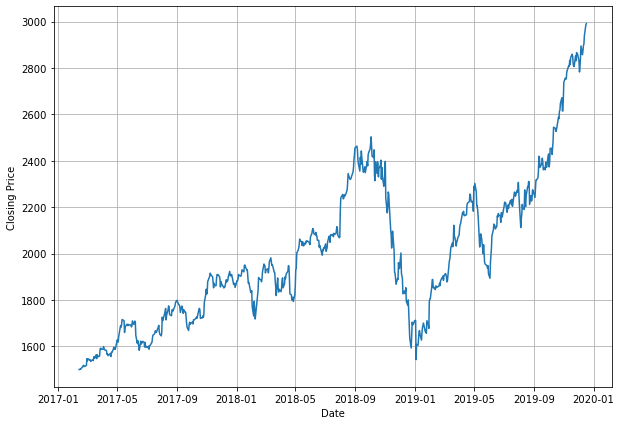

In [15]:
import matplotlib.pyplot as plt

def plot_graph(data,ylabel,xlabel):
    plt.figure(figsize = (10,7))
    plt.grid()
    plt.plot(data)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

plot_graph(portfoliomanager['leftover'] + portfoliomanager['Adj Close']*portfoliomanager['stock'], 'Closing Price', 'Date')
#Net Worth Graph